# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [107]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import random
from PIL import Image
import torch
import os
from torch.utils.data import DataLoader,Dataset
import numpy as np
import pandas as pd

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [93]:
class Config():
    training_dir = "train_mix/"
    testing_dir = "./data/faces/testing/"# TODO
    train_batch_size = 4 # 64
    train_number_epochs = 10 #100
    
class ComicRealPairDataset(Dataset):
    
    def __init__(self,
                 pair_list,
                 is_training = True,
                 pic_dir = 'train_mix/',
                 transform=None):
        self.pic_dir = pic_dir
        self.transform = transform
        self.is_training = is_training
        self.pair_list = pair_list
        real_num = len(self.pair_list)
        self.ids = [i for i in range(real_num)]# 选real作总数

    def __getitem__(self,index):
        idx = self.ids[index]
        
        real_path = self.pic_dir + self.pair_list.iat[idx, 0]
        comi_path = self.pic_dir + self.pair_list.iat[idx, 1]
        
        real_img = Image.open(real_path).convert('L')#RGB
        comi_img = Image.open(comi_path).convert('L')#RGB
        
        if self.transform is not None:
            real_img = self.transform(real_img)
            comi_img = self.transform(comi_img)
            
        if self.is_training:
            target = int(self.pair_list.iat[idx, 2])
            return real_img, comi_img, target
        else:
            return real_img, comi_img
    
    def __len__(self):
        return len(self.ids)



## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [94]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [108]:
# folder_dataset = dset.ImageFolder(root=Config.training_dir)
import pandas as pd
pair_path = 'pair_list.csv'
pair_list = pd.read_csv(pair_path, sep=',', header=0)


In [96]:
pair_dataset = ComicRealPairDataset(pair_list,
                                    transform=transforms.Compose([transforms.Resize((100,100)),#TODO
                                                                      transforms.ToTensor()
                                                                      ]),
                                    )

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

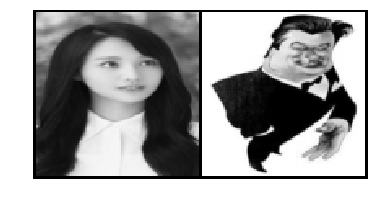

[0]


In [97]:
vis_dataloader = DataLoader(pair_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [98]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [99]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        label = label.type(torch.FloatTensor)
        x = (1-label)
        y = torch.pow(euclidean_distance, 2)
        a = x * y
        b = (label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = torch.mean((a + b))
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [100]:
train_dataloader = DataLoader(pair_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [101]:
net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [102]:
counter = []
loss_history = [] 
iteration_number= 0

In [104]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
#         img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        img0, img1 , label = torch.tensor(img0, requires_grad=True), torch.tensor(img1, requires_grad=True), torch.tensor(label, requires_grad=True)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %50 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Epoch number 0
 Current loss 1.1999588012695312

Epoch number 0
 Current loss 0.5887404680252075

Epoch number 0
 Current loss 0.7449545860290527

Epoch number 0
 Current loss 1.1752088069915771

Epoch number 0
 Current loss 4.17529296875

Epoch number 0
 Current loss 0.5521777272224426

Epoch number 0
 Current loss 1.0884499549865723

Epoch number 0
 Current loss 2.262739419937134

Epoch number 0
 Current loss 0.9425555467605591

Epoch number 0
 Current loss 1.3437846899032593

Epoch number 0
 Current loss 1.2655733823776245

Epoch number 0
 Current loss 0.6577503681182861

Epoch number 0
 Current loss 1.467374563217163

Epoch number 0
 Current loss 1.19911527633667

Epoch number 0
 Current loss 0.3138398826122284

Epoch number 0
 Current loss 4.887632846832275

Epoch number 0
 Current loss 1.5980274677276611

Epoch number 0
 Current loss 1.4179071187973022

Epoch number 0
 Current loss 0.3956337571144104

Epoch number 0
 Current loss 0.8556269407272339

Epoch number 0
 Current loss 0

D:\program\anaconda\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Epoch number 0
 Current loss 1.3531112670898438

Epoch number 0
 Current loss 1.3327691555023193

Epoch number 0
 Current loss 1.5597938299179077

Epoch number 0
 Current loss 0.3701830804347992

Epoch number 0
 Current loss 0.31155911087989807

Epoch number 0
 Current loss 1.3468703031539917

Epoch number 0
 Current loss 1.0305639505386353

Epoch number 0
 Current loss 1.0167866945266724

Epoch number 0
 Current loss 0.6623944044113159

Epoch number 0
 Current loss 1.6689189672470093

Epoch number 0
 Current loss 1.0059216022491455

Epoch number 0
 Current loss 1.6083042621612549

Epoch number 0
 Current loss 2.3809802532196045

Epoch number 0
 Current loss 1.2155383825302124

Epoch number 0
 Current loss 0.6605052947998047

Epoch number 0
 Current loss 0.18991857767105103

Epoch number 0
 Current loss 0.7586151957511902

Epoch number 0
 Current loss 0.9893255233764648

Epoch number 0
 Current loss 0.6905056238174438

Epoch number 0
 Current loss 0.6611994504928589

Epoch number 0
 Cu

D:\program\anaconda\lib\site-packages\PIL\TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch number 0
 Current loss 1.3634090423583984

Epoch number 1
 Current loss 0.7633402347564697

Epoch number 1
 Current loss 0.8147345185279846

Epoch number 1
 Current loss 1.0504608154296875

Epoch number 1
 Current loss 0.378580242395401

Epoch number 1
 Current loss 1.2233320474624634

Epoch number 1
 Current loss 0.8319326043128967



KeyboardInterrupt: 

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [114]:
root = 'af2019-ksyun-testA-20190416/'
# root = 'af2019-ksyun-testB-20190424/'
ann_path = root + 'list.csv'
df = pd.read_csv(ann_path, sep=',', header=0)
pair_list = df.ix[:, 1:]
pic_dir = root + 'images/'

pair_dataset = ComicRealPairDataset(pair_list,
                                    pic_dir = pic_dir,
                                    is_training = False,
                                    transform=transforms.Compose([transforms.Resize((100,100)),#TODO
                                                                  transforms.ToTensor()
                                                                  ]),
                                    )
  
id_confidence = []

test_dataloader = DataLoader(pair_dataset,num_workers=0,batch_size=1,shuffle=False)
for i, data in enumerate(test_dataloader, 0):
    x0, x1 = data
    x0, x1 = torch.tensor(x0), torch.tensor(x1)
    output1,output2 = net(x0,x1)
    euclidean_distance = F.pairwise_distance(output1, output2).item()
    score = max(0, 1-euclidean_distance)
    id_confidence.append([i, score])# 分数可以加调节参数改
save = pd.DataFrame(id_confidence)
save.to_csv('testA.csv',index=False,sep=',', header=['group_id', 'confidence'])

D:\program\anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
